In [36]:
import xarray as xr
import numpy as np
from File_name_generator import generate_filename_dict
from datetime import datetime

In [37]:
t_deltas = [3, 5]
agg_fact=3
t_deltas = [5]
    agg_fact = 3
target_filenames = generate_filename_dict(start_time=datetime(
        2023, 1, 8, 0, 15), end_time=datetime(2023, 1, 15, 0, 0), t_deltas=t_deltas, agg_fact=agg_fact)
target_filenames = generate_filename_dict(start_time=datetime(
    2023, 1, 1, 0, 0), end_time=datetime(2023, 1, 1, 0, 15), t_deltas=t_deltas, agg_fact=agg_fact)


All np resample_CPP files are present
All np resample_CTX files are present
All sp resample_CPP files are present
All sp resample_CTX files are present


In [38]:
fps=target_filenames["np"]["filter"]

In [39]:
min_temp=-5
max_temp=0
fps= np.char.replace(fps, "Resampled_Data", "Filtered_Data")
fps = np.char.replace(fps, f"Agg_{agg_fact:02}", f"Agg_{agg_fact:02}_T_{abs(min_temp)}_{abs(max_temp)}")
fps

array(['/wolke_scratch/dnikolo/CLAAS_Data/Filtered_Data/np/2023/01/01/Agg_03_T_5_0_20230101000000.nc',
       '/wolke_scratch/dnikolo/CLAAS_Data/Filtered_Data/np/2023/01/01/Agg_03_T_5_0_20230101001500.nc'],
      dtype='<U92')

In [40]:
ds=xr.open_mfdataset(list(target_filenames["np"]["filter"]), parallel=True, concat_dim="time", combine='nested', data_vars=["cph_resampled", "ctt_resampled"] )

In [41]:
ds

<xarray.Dataset> Size: 5MB
Dimensions:        (time: 2, lat: 299, lon: 1045)
Coordinates:
  * time           (time) datetime64[ns] 16B 2023-01-01 2023-01-01T00:15:00
  * lon            (lon) float64 8kB -79.69 -79.54 -79.39 ... 79.49 79.64 79.74
  * lat            (lat) float64 2kB 26.11 26.29 26.48 ... 80.71 80.89 81.05
Data variables:
    cph_resampled  (time, lat, lon) float32 2MB dask.array<chunksize=(1, 299, 1045), meta=np.ndarray>
    ctt_resampled  (time, lat, lon) float32 2MB dask.array<chunksize=(1, 299, 1045), meta=np.ndarray>
Attributes: (12/46)
    CDI:                                             Climate Data Interface v...
    institution:                                     EUMETSAT/CMSAF
    Conventions:                                     CF-1.7,ACDD-1.3
    filename:                                        CPPin20230101000000405SV...
    title:                                           ICDR of CM SAF CLoud pro...
    summary:                                         This file contains Cloud...
    ...                                              ...
    id:                                              DOI:10.5676/EUM_SAF_CM/C...
    references:                                      https://doi.org/10.5676/...
    license:                                         The CM SAF data are owne...
    history:                                         Sat Dec 07 19:21:46 2024...
    NCO:                                             netCDF Operators version...
    CDO:                                             Climate Data Operators v...

In [42]:
def iterative_filter(self, res_data):
        self.ctt = res_data["ctt_resampled"].to_masked_array(copy=False)
        self.cph = res_data["cph_resampled"].to_masked_array(copy=False)
        cph_filtered_list=[]
        for i in range(self.temp_bounds[0].shape[0]):
            min_temp = self.temp_bounds[0][i]
            max_temp = self.temp_bounds[1][i]
            cph_filtered_list.append(self.filter_data(min_temp, max_temp))
        return cph_filtered_list

In [43]:
def generate_temp_range(t_deltas: list) -> tuple:
    boundary_temps = np.arange(0, -38.1, -t_deltas[0])
    t_min = boundary_temps[1:].astype(int)
    t_max = boundary_temps[0:-1].astype(int)
    for i in range(len(t_deltas)-1):
        boundary_temps = np.arange(0, -38.1, -t_deltas[i+1])
        # t_ranges_temp=np.concatenate((boundary_temps[1:][None,:].astype(int),boundary_temps[0:-1][None,:].astype(int)),0,dtype='int')
        t_min = np.concatenate((t_min, boundary_temps[1:].astype(int)))
        t_max = np.concatenate((t_max, boundary_temps[0:-1].astype(int)))
    return t_min, t_max


In [44]:

temp_bounds = generate_temp_range(t_deltas)
min_temp = temp_bounds[0][0]
max_temp = temp_bounds[1][0]

In [45]:
ds['cph_resampled'].shape

(2, 299, 1045)

In [46]:

# mask = (ds['ctt_resampled'] >= 24)
# Apply the mask to cph_resampled
mask = (ds['ctt_resampled'] >= 240) & (ds['ctt_resampled'] <= 260)
# ds['cph_filtered'] = ds['cph_resampled'].where(mask)
ds['cph_filtered'] = xr.where(mask, ds['cph_resampled'], 0).compute()

In [47]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:        (time: 2, lat: 299, lon: 1045)
Coordinates:
  * time           (time) datetime64[ns] 16B 2023-01-01 2023-01-01T00:15:00
  * lon            (lon) float64 8kB -79.69 -79.54 -79.39 ... 79.49 79.64 79.74
  * lat            (lat) float64 2kB 26.11 26.29 26.48 ... 80.71 80.89 81.05
Data variables:
    cph_resampled  (time, lat, lon) float32 2MB dask.array<chunksize=(1, 299, 1045), meta=np.ndarray>
    ctt_resampled  (time, lat, lon) float32 2MB dask.array<chunksize=(1, 299, 1045), meta=np.ndarray>
    cph_filtered   (time, lat, lon) float32 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/46)
    CDI:                                             Climate Data Interface v...
    institution:                                     EUMETSAT/CMSAF
    Conventions:                                     CF-1.7,ACDD-1.3
    filename:                                        CPPin20230101000000405SV...
    title:                                           ICDR of CM SAF CLoud pro...
    summary:                                         This file contains Cloud...
    ...                                              ...
    id:                                              DOI:10.5676/EUM_SAF_CM/C...
    references:                                      https://doi.org/10.5676/...
    license:                                         The CM SAF data are owne...
    history:                                         Sat Dec 07 19:21:46 2024...
    NCO:                                             netCDF Operators version...
    CDO:                                             Climate Data Operators v...

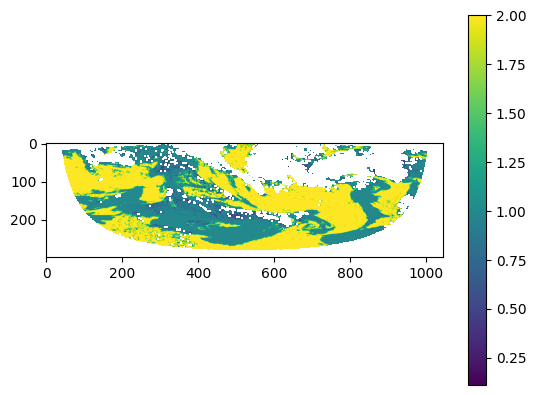

In [48]:
import matplotlib.pyplot as plt
mask = (ds['ctt_resampled'] >= 24)
plt.imshow(ds['cph_resampled'].where(( ds['ctt_resampled'] >= 24) &  ( ds['ctt_resampled'] >= 24))[0,:,:])
plt.colorbar()

In [49]:
_ , dataset_list = zip(*ds.groupby("time"))
len(dataset_list)
dataset_list[1]["cph"].encoding.pop('source')
dataset_list[1]["cph"].attrs

KeyError: "No variable named 'cph'. Variables on the dataset include ['cph_resampled', 'ctt_resampled', 'time', 'lon', 'lat', 'cph_filtered']"

In [ ]:
xr.save_mfdataset(dataset_list, ["/wolke_scratch/dnikolo/CLAAS_Data/Filtered_Data/a.nc", "/wolke_scratch/dnikolo/CLAAS_Data/Filtered_Data/b.nc"])

In [ ]:

# Filter by temperature range -38C<T<0C
ctt_filtered = np.ma.masked_where((self.ctt < 273.15 + min_temp)
                                    | (self.ctt > 273.15 + max_temp), self.ctt)
# Create a combined mask that only has entries at positions within temp range and valid phase
cph_filtered = self.cph.copy()
cph_filtered.mask = ctt_filtered.mask | self.cph.mask
return cph_filtered    

NameError: name 'self' is not defined

In [ ]:
mfdata.cph_resampled